# Day Trading 

## MA Deviation from Real Line (Closing Price)

We want to compute the MA's to inform us which MA lies closest to the RL. We can usually visually make this judgement however we can calculated the SSE the statsitical determine this.

Next, we are going to compute the SSE (Sum of Squared Errors) which is a strong statistical measurement when assessing Linear Regression models. Here, we want to determine it's usecase in the realms of Stocks and Trading.

Can we pinpoint early detection/trigger points when stocks are regressing from expected values. Essentially, can we leverage the MA statistics to determine values that may indicate price movements in the future.

We are looking at two angles how the shortening of the space between the two lines can be a trigger point. Can we determine values from our deviation calculations such as the mean, std etc. to be threshold points (early detection/triggers)

What is happening when the space between both lines lenghtens ?

### Resistance Bands

Bollinger Bands (Compute)
- Middle Band (MA): This is the simple moving average (SMA) of the closing prices over a specified period. A common choice is a 20-period SMA.
- Upper Band (UB): This is the sum of the 20-period SMA and two times the 20-period standard deviation (SD) of the closing prices.
- Lower Band (LB): This is the 20-period SMA minus two times the 20-period SD of the closing prices.

Bollinger Bands (Interpretation)
- When the price moves close to the upper band (UB), it may indicate overbought conditions, suggesting a potential price reversal to the downside.
- Conversely, when the price approaches the lower band (LB), it may indicate oversold conditions, suggesting a potential price reversal to the upside.
- The middle band (MA) represents the average price over the specified period and can serve as a reference point.


In [16]:
import numpy as np # fundamental package for scientific computing in Python.
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # data visualization library

import random # generate the pseudo-random variables

# Small-scale Dataset Testing

Here we want to test the affect -/+ values when computing our data.

We can see from below values there is no impact.

In [17]:
#Create empty lists for indepedent variabes
X1, X2 = ([] for i in range(2)) # range() function returns a sequence of numbers, starting from 0 by default, and increments by 1 (by default), and stops before a specified number.

#Initiate for loop to generate data
for n in range(0,10):
    number1 = random.randint(-10,15)
    X1.append(number1)
    number2 = random.randint(-10,10)
    X2.append(number2)
    
#Create DataFrame including all above features and randomly generated data
df_x = pd.DataFrame ({'Price':X1,'MA':X2})
#create a copy of original dataframe ...(good practice)
original_dataframe = df_x.copy(deep = True)

# deviations
df_x['Deviation'] = df_x['Price'] - df_x['MA']
df_x['deviation_squared'] = df_x['Deviation'] ** 2

#Display head of dataframe, dataset information, summary information & dataframe size
display(df_x.head(), df_x.info(), df_x.describe(), df_x.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Price              10 non-null     int64
 1   MA                 10 non-null     int64
 2   Deviation          10 non-null     int64
 3   deviation_squared  10 non-null     int64
dtypes: int64(4)
memory usage: 448.0 bytes


,Price,MA,Deviation,deviation_squared
0,9,1,8,64
1,-3,-8,5,25
2,10,5,5,25
3,14,-3,17,289
4,-7,-3,-4,16


None

,Price,MA,Deviation,deviation_squared
count,10.000000,10.000000,10.000000,10.000000
mean,4.700000,-1.300000,6.000000,118.800000
std,7.543209,5.396501,9.591663,95.929141
min,-7.000000,-8.000000,-16.000000,16.000000
25%,-1.250000,-4.500000,5.000000,34.750000
50%,7.000000,-3.000000,9.000000,100.000000
75%,10.000000,0.500000,11.500000,162.750000
max,14.000000,10.000000,17.000000,289.000000


(10, 4)

# Stocks and Shares (Real-Dataset)

In [18]:
# Read in CSV data to Dataframe
df = pd.read_csv('ADM.csv')
saved_df = df.copy(deep = True) # create copy of orginal dataframe

# Drop Multiple Columns (not required for this analysis)
df = df.drop(['Open','High','Low','Volume','Adj Close'], axis=1)

#
df

,Date,Close
0,1980-03-17,1.848521
1,1980-03-18,1.907607
2,1980-03-19,1.932929
3,1980-03-20,1.983573
4,1980-03-21,1.932929
...,...,...
10093,2020-03-26,34.459999
10094,2020-03-27,33.500000
10095,2020-03-30,35.830002
10096,2020-03-31,35.180000


### Feature Engineering

In [19]:
# Price Change 
df['closing_price_change'] = df['Close'].diff() # difference (daily price) between the values in current row and previous row
df['pct_change'] = df['Close'].pct_change() # percentage change daily price

# MA's
# Moving Average -->> SMA (simple moving averages)
df['short_sma'] = df.Close.rolling(window=12).mean() # SMA -->> simple moving average (SMA)
df['deviation'] = df['Close'] - df['short_sma'] # Deviation (Price - SMA)
df['dev_squared'] = df['deviation'] ** 2
df['50ema'] = df['Close'].ewm(span=50,adjust=False).mean() # -->> exponential moving average (50 day EMA) (weight on recent prices)
df['200ema'] = df['Close'].ewm(span=200,adjust=False).mean() # -->> exponential moving average (200 day EMA) (weight on recent prices)


# RSI
# Relative Strenght Index (RSI)
delta = df['Close'].diff()
gain = (delta.where(delta>0,0)).rolling(window=14).mean() # average gains (MAs)
loss = (-delta.where(delta<0,0)).rolling(window=14).mean() # average losses (MAs)
rs = gain/loss # RS = avg_gains/avg_losses
rsi = 100 - (100/(1+rs))
df['RSI'] = rsi # rsi value
df['rsi_change'] = df.RSI.diff() # rsi_change()

#
#  RSI direction change
rsi_c = [] # empty list
for val in df['rsi_change']:
    if (val>= 0):
        rsi_c.append(1)
    else:
        rsi_c.append(0)           
df['rsi_change_direction'] = rsi_c # Postive v Negative (Trend Direction)

#
# RSI overbought v oversold flag
indicator = []
for i in range(len(df)):
    if df['RSI'][i] > 70:
        indicator.append("RSI_overbought_indicator")
    elif df['RSI'][i] < 30:
        indicator.append("RSI_oversold_indicator")
    else:
       indicator.append(np.nan)
df['rsi_indicator'] = indicator


# BOLLINGOR BANDS (SMA, UpperBand + LowerBand)
df['bollingor_band_sma'] = df['Close'].rolling(window=20).mean() # Calculate the 20-period Simple Moving Average (SMA)
df['bb_sma_std'] = df['Close'].rolling(window=20).std() # Calculate the 20-period Standard Deviation (SD)
df['bb_upper_band'] = df['bollingor_band_sma'] + 2 * df['bb_sma_std'] # Calculate the Upper Bollinger Band (UB) x2 std above
df['bb_lower_band'] = df['bollingor_band_sma'] - 2 * df['bb_sma_std'] # Calculate the Lower Bollinger Band (LB) x2 std below


# SSE (Sum of Squared Errors)
print('SSE :', df.dev_squared.sum().round(2))
df

SSE : 5654.84


,Date,Close,closing_price_change,pct_change,short_sma,deviation,dev_squared,50ema,200ema,RSI,rsi_change,rsi_change_direction,rsi_indicator,bollingor_band_sma,bb_sma_std,bb_upper_band,bb_lower_band
0,1980-03-17,1.848521,NaN,NaN,NaN,NaN,NaN,1.848521,1.848521,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,1980-03-18,1.907607,0.059085,0.031964,NaN,NaN,NaN,1.850839,1.849109,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2,1980-03-19,1.932929,0.025322,0.013274,NaN,NaN,NaN,1.854058,1.849943,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
3,1980-03-20,1.983573,0.050644,0.026201,NaN,NaN,NaN,1.859137,1.851273,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
4,1980-03-21,1.932929,-0.050644,-0.025532,NaN,NaN,NaN,1.862031,1.852086,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10093,2020-03-26,34.459999,1.759998,0.053823,32.922500,1.537499,2.363904,38.666326,41.417643,44.584466,4.534983,1,NaN,34.8690,2.909047,40.687095,29.050905
10094,2020-03-27,33.500000,-0.959999,-0.027858,32.791667,0.708333,0.501736,38.463725,41.338860,46.783417,2.198951,1,NaN,34.6615,2.847600,40.356699,28.966301
10095,2020-03-30,35.830002,2.330002,0.069552,33.149167,2.680835,7.186878,38.360442,41.284046,47.736052,0.952635,1,NaN,34.5110,2.690335,39.891671,29.130329
10096,2020-03-31,35.180000,-0.650002,-0.018141,33.194167,1.985834,3.943535,38.235719,41.223309,50.203028,2.466976,1,NaN,34.3670,2.564511,39.496022,29.237978


In [20]:
df.describe()

,Close,closing_price_change,pct_change,short_sma,deviation,dev_squared,50ema,200ema,RSI,rsi_change,rsi_change_direction,bollingor_band_sma,bb_sma_std,bb_upper_band,bb_lower_band
count,10098.000000,10097.000000,10097.000000,10087.000000,10087.000000,10087.000000,10098.000000,10098.000000,10085.000000,10084.000000,10098.000000,10079.000000,10079.000000,10079.000000,10079.000000
mean,19.426913,0.003171,0.000483,19.428708,0.017358,0.560607,19.339045,19.039657,51.496162,-0.000052,0.516043,19.430143,0.531121,20.492385,18.367901
std,14.718390,0.428196,0.019727,14.705878,0.748573,1.791642,14.648786,14.429587,16.030163,6.939769,0.499767,14.697953,0.523675,15.448885,13.985189
min,1.381928,-4.060001,-0.198925,1.469171,-5.660832,0.000000,1.535385,1.724507,0.000000,-34.166670,0.000000,1.484526,0.019361,1.550834,1.350596
25%,8.074142,-0.110001,-0.009695,8.188217,-0.201136,0.007232,7.996387,7.368130,40.482570,-4.093568,0.000000,8.188604,0.173993,8.665439,7.575956
50%,13.810000,0.000000,0.000000,13.826543,0.021666,0.057844,13.808225,13.401769,51.702796,0.000000,1.000000,13.822500,0.358498,14.539008,13.112116
75%,31.917500,0.133333,0.010545,31.817083,0.278333,0.322019,31.524875,30.653463,62.962982,4.166667,1.000000,31.784750,0.712855,33.457865,30.172368
max,53.709999,3.900002,0.173378,52.955000,5.495001,32.045024,51.147094,49.004084,99.526056,40.572499,1.000000,52.429000,3.824819,55.066595,51.086923


### Visualization

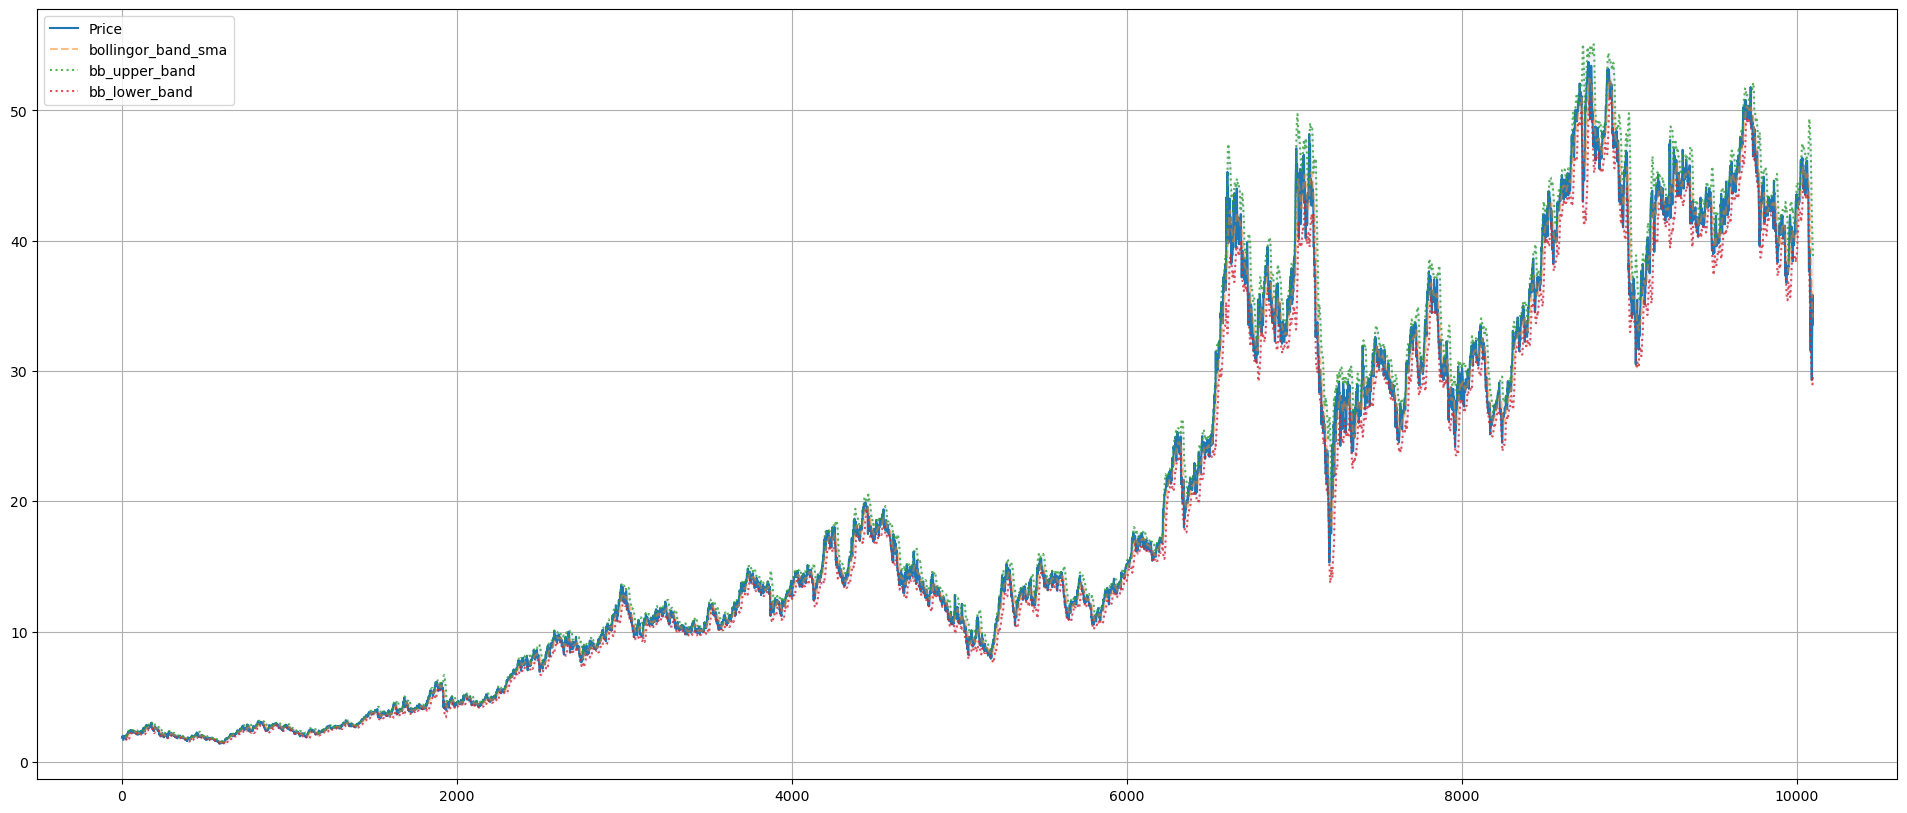

In [21]:
plt.figure(figsize=[24,10])
plt.grid(True)
#
plt.plot(df['Close'],label='Price')
#
plt.plot(df['bollingor_band_sma'],label='bollingor_band_sma',alpha=0.5,linestyle='--')
plt.plot(df['bb_upper_band'],label='bb_upper_band',alpha=0.8,linestyle=':')
plt.plot(df['bb_lower_band'],label='bb_lower_band',alpha=0.8,linestyle=':')
plt.fill_between(x=df.index, y1=df['bb_upper_band'], y2=df['bb_lower_band'], color='blue', alpha=0.05)
#
plt.legend(loc=2)

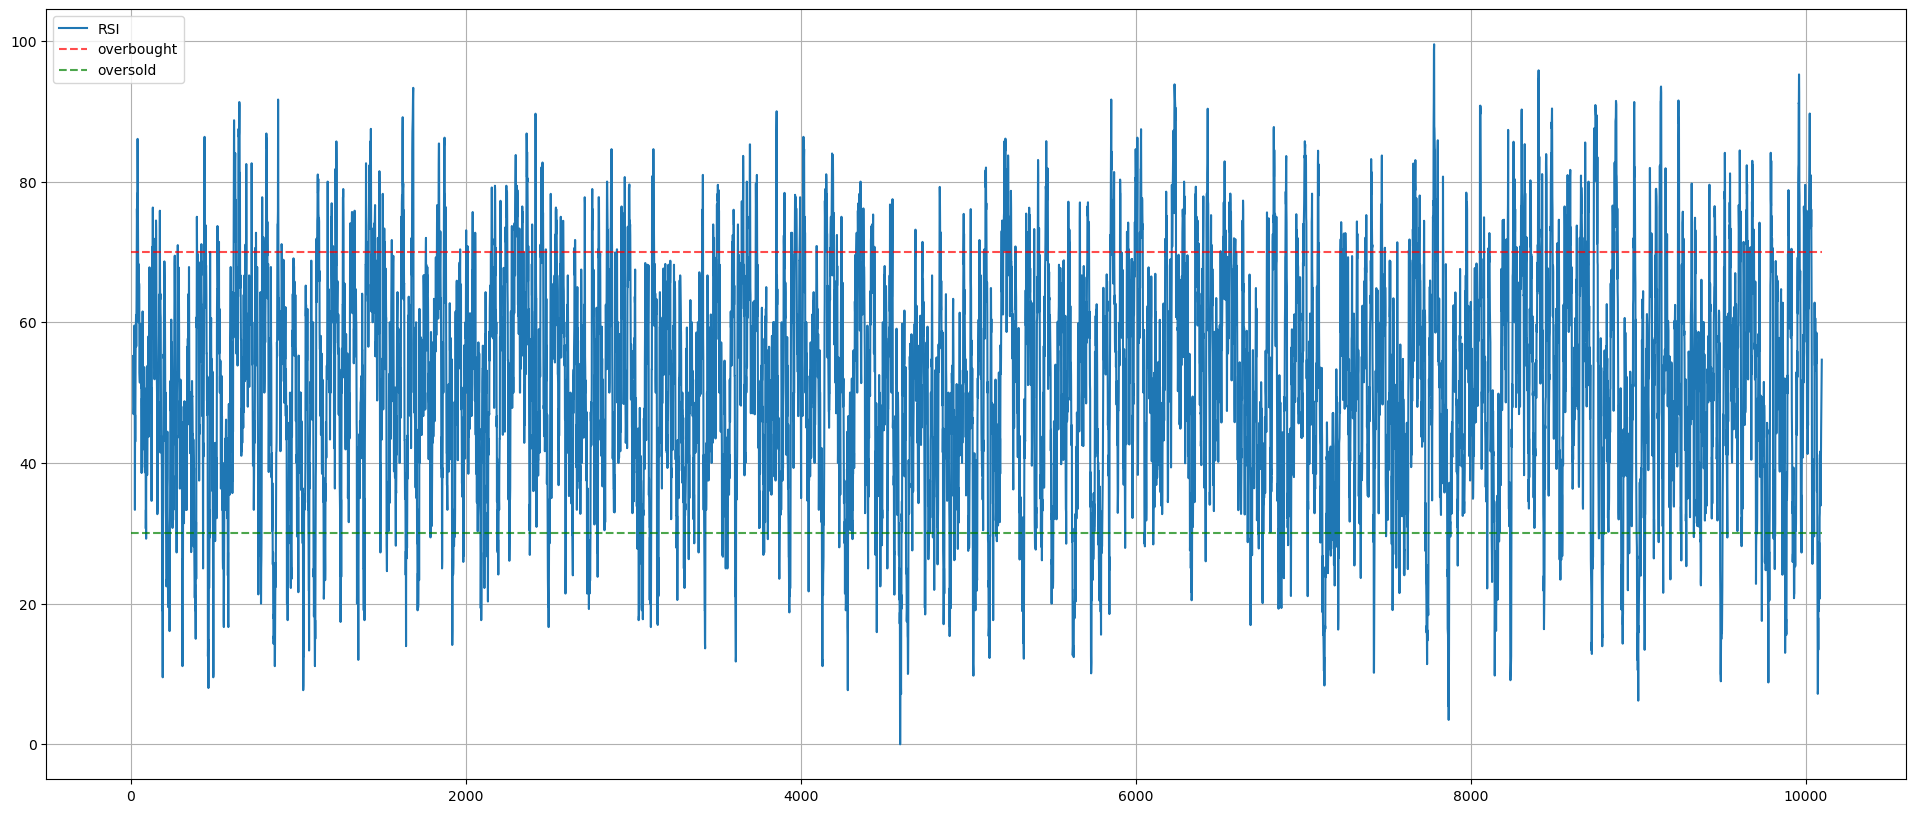

In [22]:
x1,y1 = [0,df.index[-1]],[70,70] # overbought
x2,y2 = [0,df.index[-1]],[30,30] # oversold


plt.figure(figsize=[24,10])
plt.grid(True)
plt.plot(df['RSI'],label='RSI')
plt.plot(x1, y1,label='overbought',color='red',alpha=0.7,linestyle='--')
plt.plot(x2, y2,label='oversold',color='green',alpha=0.7,linestyle='--')

plt.legend(loc=2)

# Strategy (Test)

TRIGGER/ALERT
1. RSI (overbought vs oversold)
2. Bollingor Band (overbought vs oversold conditions)

In [23]:
# subset of data
df = df.iloc[6600:7000]
df.reset_index(inplace=True) # Reset the index to default integer index

In [24]:
buy_signals = [] # (note RSI <= 30 considered oversold-->> buy) + + (Price moves close to Bollingor Lower Band considered oversold conditions -->> buy)
sell_signals = [] # (RSI >= 70 considered overbought -->> sale) + (Price moves close to Bollingor Upper Band considered overbought conditions -->> sale)

for i in range(len(df)):
    # BUY trigger
    if df['RSI'][i] <= 30 and df['Close'][i] <= df['bollingor_band_sma'][i] + 1.9 * df['bb_sma_std'][i]:
        buy_signals.append(df['Close'][i])
        sell_signals.append(np.nan)
    # SELL trigger
    elif df['RSI'][i] >= 70 and df['Close'][i] >= df['bollingor_band_sma'][i] - 1.9 * df['bb_sma_std'][i]:
        sell_signals.append(df['Close'][i])
        buy_signals.append(np.nan)
    else:
       buy_signals.append(np.nan)
       sell_signals.append(np.nan)

#Create DataFrame including all above features and randomly generated data
strategy = pd.DataFrame ({'Date':df.Date,'Price':df.Close,'short_sma':df.short_sma,
                          'RSI':df.RSI,'RSI_Indicator':df.rsi_indicator,
                          'bollingor_band_sma':df.bollingor_band_sma,
                          'bb_sma_std':df.bb_sma_std,
                          'bb_upper_band':df.bb_upper_band,'bb_lower_band':df.bb_lower_band,
                          'buy_signals':buy_signals,'sell_signals':sell_signals})
strategy

,Date,Price,short_sma,RSI,RSI_Indicator,bollingor_band_sma,bb_sma_std,bb_upper_band,bb_lower_band,buy_signals,sell_signals
0,2006-05-10,45.000000,40.290833,69.906923,NaN,39.0910,3.036995,45.164990,33.017010,NaN,NaN
1,2006-05-11,45.250000,41.005834,69.416702,NaN,39.4840,3.302267,46.088533,32.879467,NaN,NaN
2,2006-05-12,44.099998,41.603333,64.851227,NaN,39.8465,3.394544,46.635589,33.057411,NaN,NaN
3,2006-05-15,43.150002,42.183334,66.839921,NaN,40.1920,3.359625,46.911251,33.472749,NaN,NaN
4,2006-05-16,44.130001,42.832500,68.036071,NaN,40.5595,3.368738,47.296977,33.822024,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
395,2007-12-04,37.029999,36.179166,47.727272,NaN,36.4975,0.760116,38.017733,34.977267,NaN,NaN
396,2007-12-05,36.830002,36.090833,43.698639,NaN,36.4945,0.758603,38.011705,34.977294,NaN,NaN
397,2007-12-06,37.880001,36.215000,55.570138,NaN,36.5650,0.819297,38.203593,34.926406,NaN,NaN
398,2007-12-07,38.549999,36.393333,54.435488,NaN,36.6295,0.921317,38.472135,34.786865,NaN,NaN


In [25]:
# -->> signals (filtered nan values out)
buys = strategy[strategy['buy_signals'].notna()]
sells = strategy[strategy['sell_signals'].notna()]

buys

,Date,Price,short_sma,RSI,RSI_Indicator,bollingor_band_sma,bb_sma_std,bb_upper_band,bb_lower_band,buy_signals,sell_signals
69,2006-08-17,39.730000,41.095000,28.731784,RSI_oversold_indicator,41.5165,1.348443,44.213386,38.819615,39.730000,NaN
85,2006-09-11,38.330002,40.952500,21.323572,RSI_oversold_indicator,40.9265,0.961787,42.850074,39.002926,38.330002,NaN
86,2006-09-12,37.169998,40.571667,16.946605,RSI_oversold_indicator,40.7795,1.268819,43.317137,38.241863,37.169998,NaN
87,2006-09-13,37.860001,40.248333,23.380342,RSI_oversold_indicator,40.6215,1.424494,43.470488,37.772513,37.860001,NaN
88,2006-09-14,38.560001,39.987500,29.350680,RSI_oversold_indicator,40.5270,1.497300,43.521600,37.532401,38.560001,NaN
89,2006-09-15,38.130001,39.729167,27.798308,RSI_oversold_indicator,40.4470,1.582447,43.611894,37.282107,38.130001,NaN
94,2006-09-22,38.480000,38.585834,29.942862,RSI_oversold_indicator,39.7435,1.583837,42.911174,36.575826,38.480000,NaN
95,2006-09-25,37.619999,38.393333,26.882857,RSI_oversold_indicator,39.5375,1.578420,42.694340,36.380660,37.619999,NaN
132,2006-11-15,35.650002,35.531667,29.904767,RSI_oversold_indicator,36.6765,1.824140,40.324780,33.028220,35.650002,NaN
135,2006-11-20,33.500000,34.907500,27.836877,RSI_oversold_indicator,36.2105,1.966363,40.143226,32.277774,33.500000,NaN


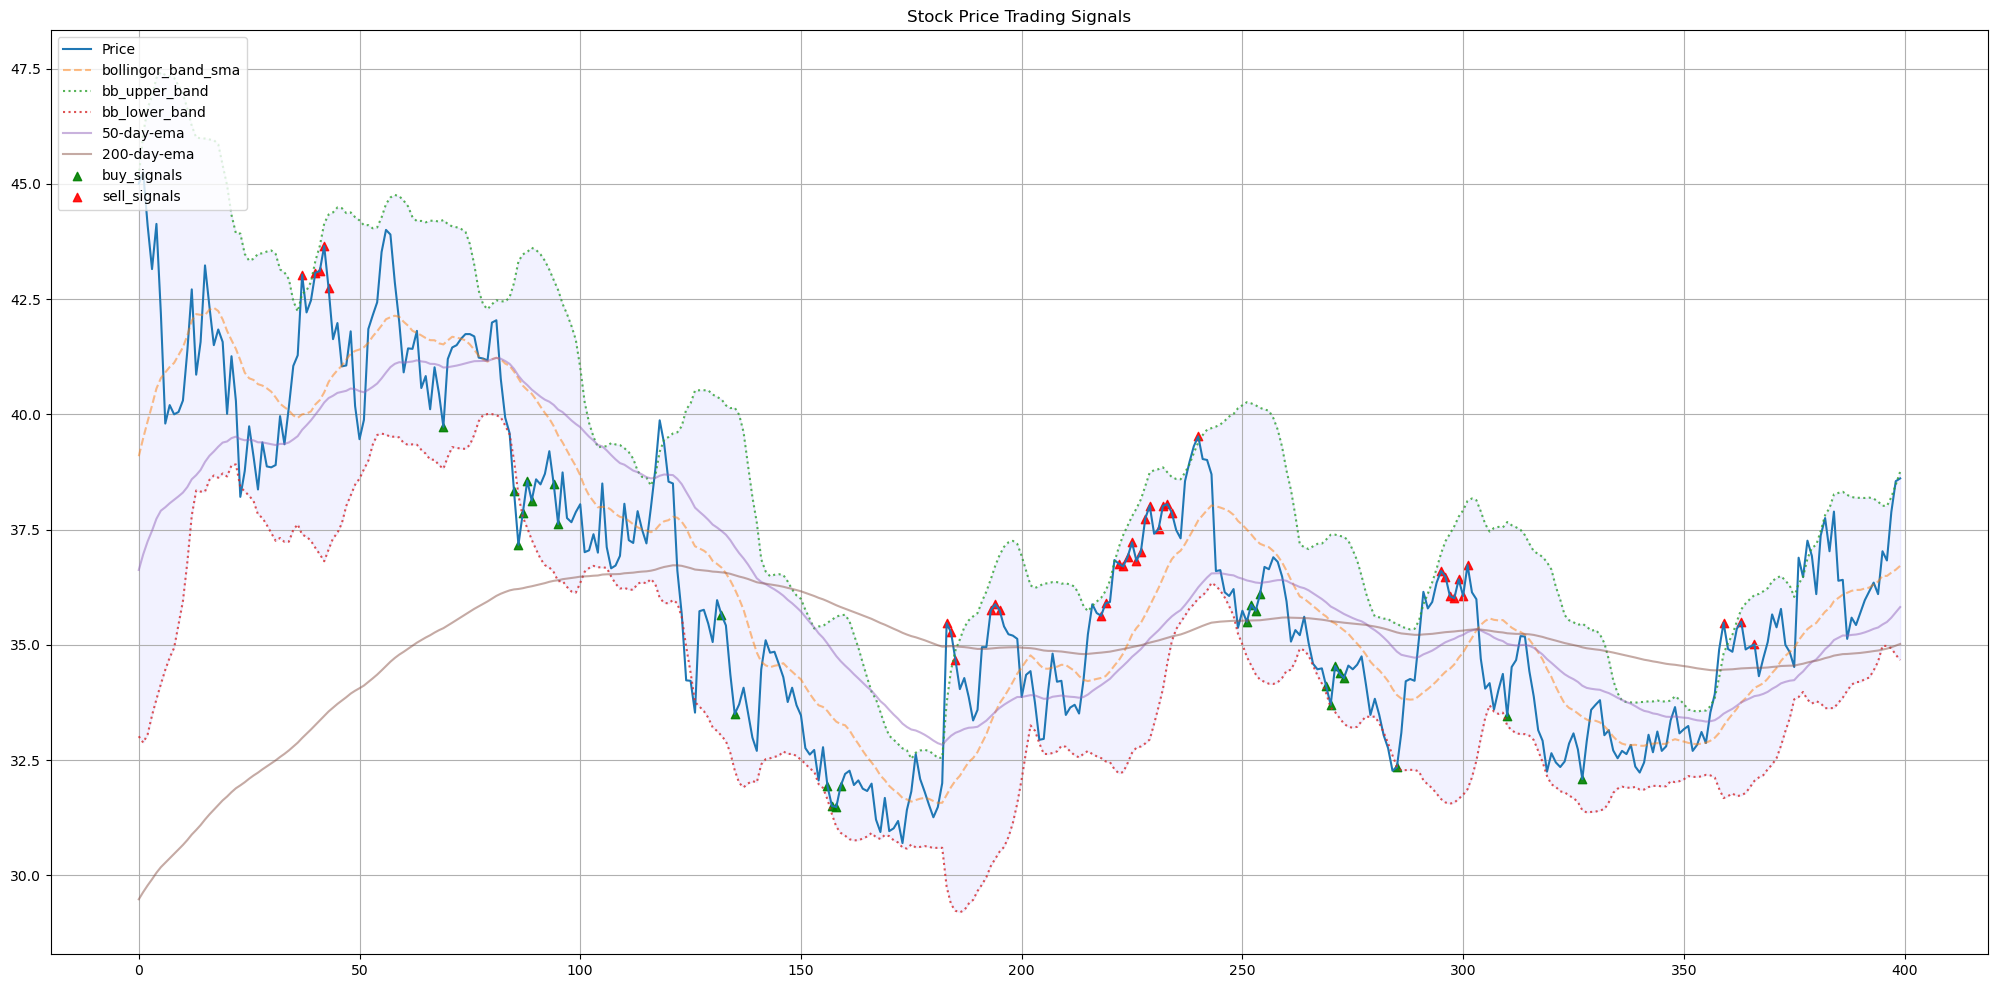

In [26]:
plt.figure(figsize=[25,12])
plt.grid(True)
plt.plot(strategy['Price'],label='Price')
plt.plot(strategy['bollingor_band_sma'],label='bollingor_band_sma',alpha=0.5,linestyle='--')
#
plt.plot(df['bb_upper_band'],label='bb_upper_band',alpha=0.8,linestyle=':')
plt.plot(df['bb_lower_band'],label='bb_lower_band',alpha=0.8,linestyle=':')
plt.fill_between(x=df.index, y1=df['bb_upper_band'], y2=df['bb_lower_band'], color='blue', alpha=0.05)
#
plt.plot(df['50ema'],label='50-day-ema',alpha=0.5)
plt.plot(df['200ema'],label='200-day-ema',alpha=0.5)
#
plt.scatter(x=strategy.index,y=strategy.buy_signals,marker='^',color='green',label='buy_signals',alpha=0.9)
plt.scatter(x=strategy.index,y=strategy.sell_signals,marker='^',color='red',label='sell_signals',alpha=0.9)
plt.title('Stock Price Trading Signals')

plt.legend(loc=2)


# BACK-TEST

In [27]:
def back_t1(dataframe,index1,index2):
    global test
    test = dataframe.iloc[index1:index2]
    # Drop Multiple Columns (not required for this analysis)
    #test = test.drop(['Date','price_difference_sma','short_ema','long_ema','macd','signal'], axis=1)

    plt.grid(True)
    plt.plot(test['Close'],label='Price')
    plt.plot(test['short_sma'],label='sma',alpha=0.5,linestyle='--')

    plt.title('Backtest')
    plt.legend(loc=2)

    print(test['Close'].std())

In [28]:
for i in range (len(test)):
    if test['closing_price_change'][i] >=  0.04:
        print("Trending-Upwards",test.index[i],test['Close'][i])
        print("----------------------------------------------------")
    elif test['closing_price_change'][i] <=  0.03:
        print("Trending-Downwards",test.index[i],test['Close'][i])
        print("----------------------------------------------------")


print(test[['Close','closing_price_change']])

# plt.figure(figsize=[24,10])
plt.grid(True)
plt.plot(test['Close'],label='Price')
plt.plot(test['short_sma'],label='sma',alpha=0.5,linestyle='--')
#plt.scatter(x=test.index,y=test.sma_alert,marker='^',color='red',label='alert',alpha=0.9)
plt.title('Backtest')
plt.legend(loc=2)
     
        

NameError: name 'test' is not defined